# 0.Import modules

In [1]:
import sys
import os
from pathlib import Path

import gc
import warnings

from datetime import datetime
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as se
import scipy.stats as stats

import ipywidgets as widgets
from tqdm import tqdm


In [2]:

# Set view options
se.set(style='white', context='notebook', rc={'figure.figsize': (14, 10)})

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

warnings.filterwarnings('ignore')

%matplotlib inline

# 1.Load data

1. train.csv - the training set

    1.1 row_id - An ID code for the row.

    1.2 cfips - A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.

    1.3 county_name - The written name of the county.

    1.4 state_name - The name of the state.

    1.5 first_day_of_month - The date of the first day of the month.

    1.6 microbusiness_density - Microbusinesses per 100 people over the age of 18 in the given county. This is the target variable. The population figures used to calculate the density are on a two-year lag due to the pace of update provided by the U.S. Census Bureau, which provides the underlying population data annually. 2021 density figures are calculated using 2019 population figures, etc.
    
    1.7 active - The raw count of microbusinesses in the county. Not provided for the test set.

2. revealed_test.csv - the new part of train set. The same scheme as train.csv

3. census_starter.csv Examples of useful columns from the Census Bureau's American Community Survey (ACS) at data.census.gov. The percentage fields were derived from the raw counts provided by the ACS. All fields have a two year lag to match what information was avaiable at the time a given microbusiness data update was published.

    3.1 pct_bb_[year] - The percentage of households in the county with access to broadband of any type. Derived from ACS table B28002: PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD.

    3.2 cfips - The CFIPS code.

    3.3 pct_college_[year] - The percent of the population in the county over age 25 with a 4-year college degree. Derived from ACS table S1501: EDUCATIONAL ATTAINMENT.

    3.4 pct_foreign_born_[year] - The percent of the population in the county born outside of the United States. Derived from ACS table DP02: SELECTED SOCIAL CHARACTERISTICS IN THE UNITED STATES.

    3.5 pct_it_workers_[year] - The percent of the workforce in the county employed in information related industries. Derived from ACS table S2405: INDUSTRY BY OCCUPATION FOR THE CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER.
    3.6 median_hh_inc_[year] - The median household income in the county. Derived from ACS table S1901: INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS).

4. test.csv Metadata for the submission rows. This file will remain unchanged throughout the competition.

    4.1 row_id - An ID code for the row.

    4.2 cfips - A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.

    4.3 first_day_of_month - The date of the first day of the month.

5. sample_submission.csv A valid sample submission. This file will remain unchanged throughout the competition.

    5.1 row_id - An ID code for the row.
    
    5.2 microbusiness_density - The target variable.

In [3]:
#Paths
DATA_PATH = Path("../data")
DATA_PROCESSED_PATH = DATA_PATH / "processed"

In [4]:
train = pd.read_csv(DATA_PATH / "raw/train.csv")
train_revealed = pd.read_csv(DATA_PATH / "raw/revealed_test.csv")

submission_template = pd.read_csv(DATA_PATH / "raw/test.csv")
census = pd.read_csv(DATA_PATH / "raw/census_starter.csv")
submission_example = pd.read_csv(DATA_PATH / "raw/sample_submission.csv")

train = pd.concat([train, train_revealed])

train['ds'] = pd.to_datetime(train['first_day_of_month'])
train['year'] = train['ds'].dt.year
train['month'] = train['ds'].dt.month

# 2.Data preparation

## 2.1.Target modification

1. The target variable is microbusiness_density. we need to multiply it by active to prevent target shift. Or just use active as target.
2. 

In [5]:
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,ds,year,month
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019-08-01,2019,8
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019-09-01,2019,9
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019-10-01,2019,10
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019-11-01,2019,11
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019-12-01,2019,12


In [6]:
COLS = ["GEO_ID", "NAME", "S0101_C01_026E"]

def get_adult_population(year: int) -> pd.DataFrame:
    df = pd.read_csv(
        DATA_PATH / f"external/census/ACSST5Y{year}.S0101-Data.csv", usecols=COLS
    )
    df.rename(
        columns={"S0101_C01_026E": "adult_population", "NAME": "county_state"},
        inplace=True,
    )
    df = df.iloc[1:]
    df["adult_population"] = df["adult_population"].astype("int")
    df["cfips"] = df.GEO_ID.apply(lambda x: int(x.split("US")[-1]))
    df["year"] = year + 2
    return df

years = [2017, 2018, 2019, 2020, 2021]

adult_population = pd.concat([get_adult_population(year) for year in years])


In [7]:
train = train.merge(adult_population, on=["cfips", "year"], how="left")

In [8]:
train["dcount"] = train.groupby(['cfips'])['row_id'].cumcount()


In [9]:
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,ds,year,month,GEO_ID,county_state,adult_population,dcount
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019-08-01,2019,8,0500000US01001,"Autauga County, Alabama",41527,0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019-09-01,2019,9,0500000US01001,"Autauga County, Alabama",41527,1
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019-10-01,2019,10,0500000US01001,"Autauga County, Alabama",41527,2
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019-11-01,2019,11,0500000US01001,"Autauga County, Alabama",41527,3
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019-12-01,2019,12,0500000US01001,"Autauga County, Alabama",41527,4


<AxesSubplot:xlabel='ds'>

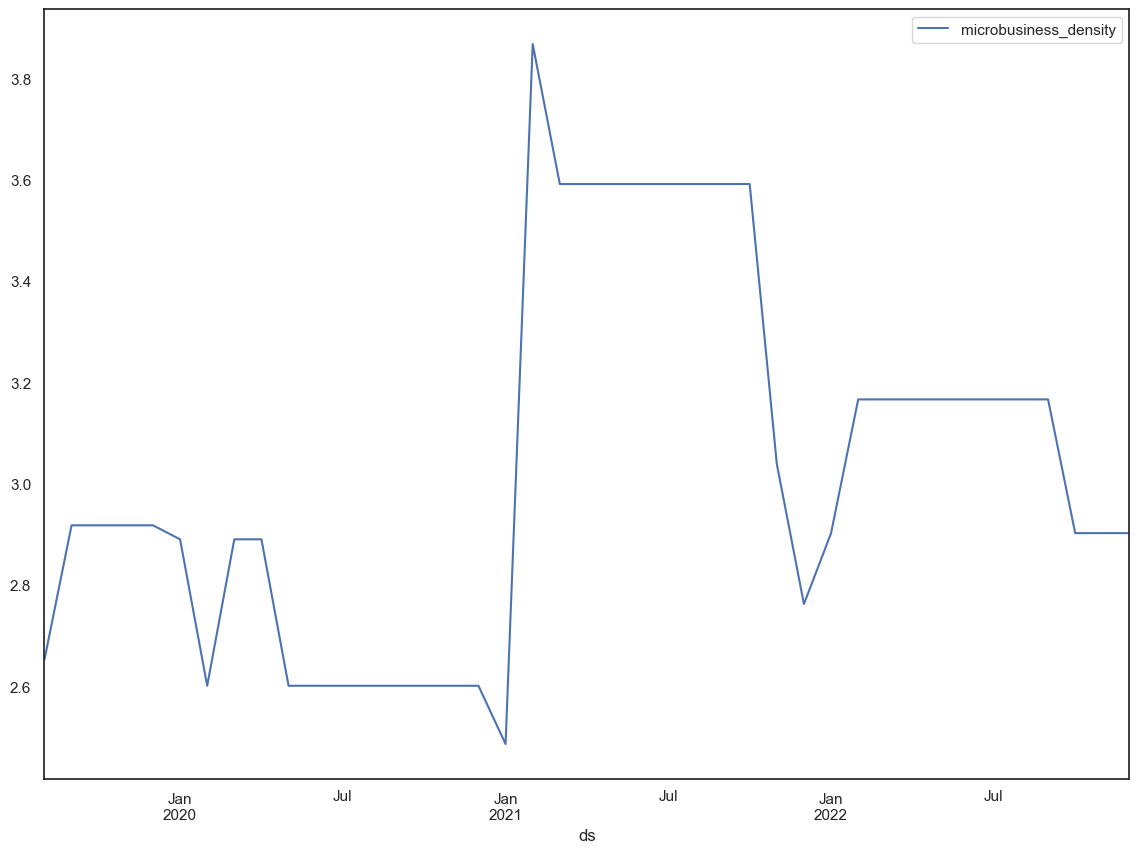

In [10]:
train[train.cfips == 30069].plot(x='ds', y='microbusiness_density')

<AxesSubplot:xlabel='ds'>

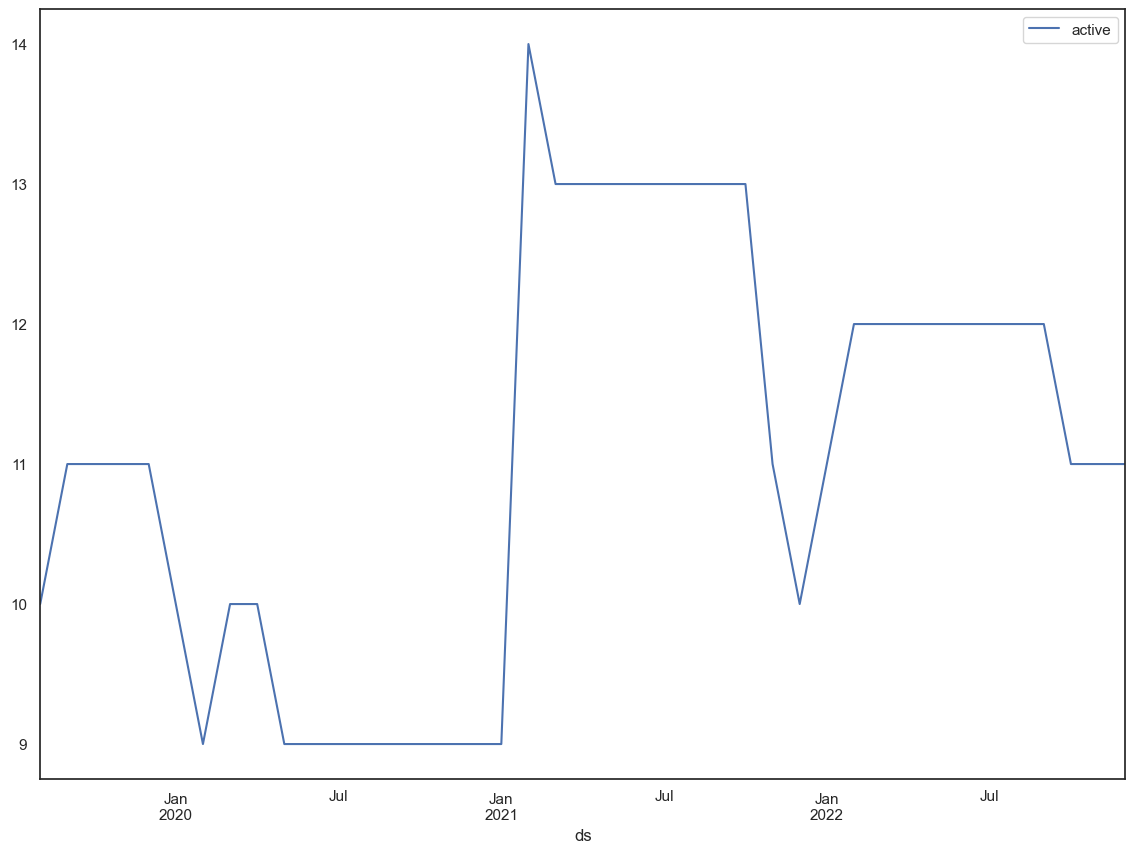

In [11]:
train[train.cfips == 30069].plot(x='ds', y='active')

## 2.2.Outliers

In [12]:
#Get basic features
train = train.sort_values(['cfips','row_id']).reset_index(drop=True)

train['first_day_of_month'] = pd.to_datetime(train["first_day_of_month"])
train['county'] = train.groupby('cfips')['county'].ffill()
train['state'] = train.groupby('cfips')['state'].ffill()
train["year"] = train["first_day_of_month"].dt.year
train["month"] = train["first_day_of_month"].dt.month
train["dcount"] = train.groupby(['cfips'])['row_id'].cumcount()
train['county_i'] = (train['county'] + train['state']).factorize()[0]
train['state_i'] = train['state'].factorize()[0]

NameError: name 'train_mod' is not defined

<AxesSubplot:xlabel='dcount'>

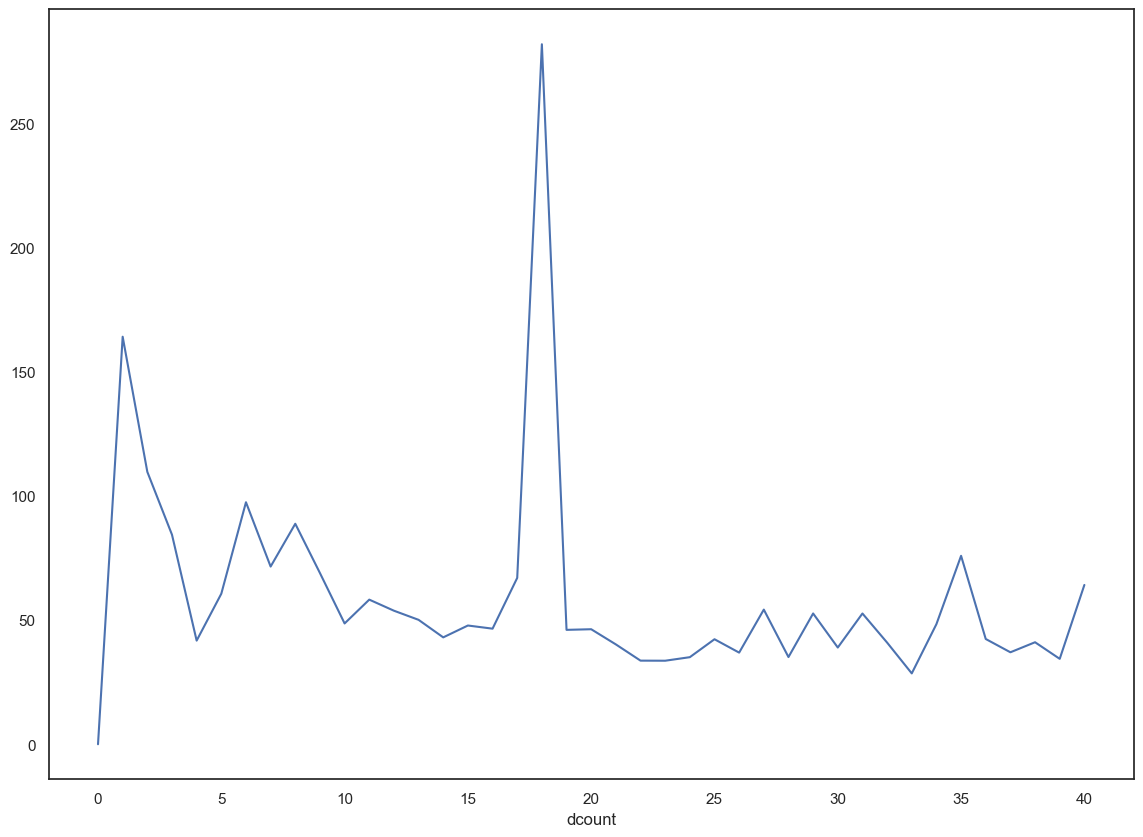

In [ ]:
lag = 1
train[f'mbd_lag_{lag}'] = train.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
train['dif'] = (train['microbusiness_density'] / train[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
train.loc[(train[f'mbd_lag_{lag}']==0), 'dif'] = 0
train.loc[(train[f'microbusiness_density']>0) & (train[f'mbd_lag_{lag}']==0), 'dif'] = 1
train['dif'] = train['dif'].abs()
train.groupby('dcount')['dif'].sum().plot()

In [ ]:
outliers = []
cnt = 0
for o in tqdm(train.cfips.unique()):
    indices = (train['cfips']==o)
    tmp = train.loc[indices].copy().reset_index(drop=True)
    var = tmp.microbusiness_density.values.copy()
    for i in range(37, 2, -1):
        thr = 0.20*np.mean(var[:i])
        difa = abs(var[i]-var[i-1])
        if (difa>=thr):
            var[:i] *= (var[i]/var[i-1])
            outliers.append(o)
            cnt+=1
    var[0] = var[1]*0.99
    train.loc[indices, 'microbusiness_density'] = var   
outliers = np.unique(outliers)
len(outliers), cnt

100%|██████████| 3135/3135 [00:05<00:00, 598.54it/s]


(481, 732)

<AxesSubplot:xlabel='dcount'>

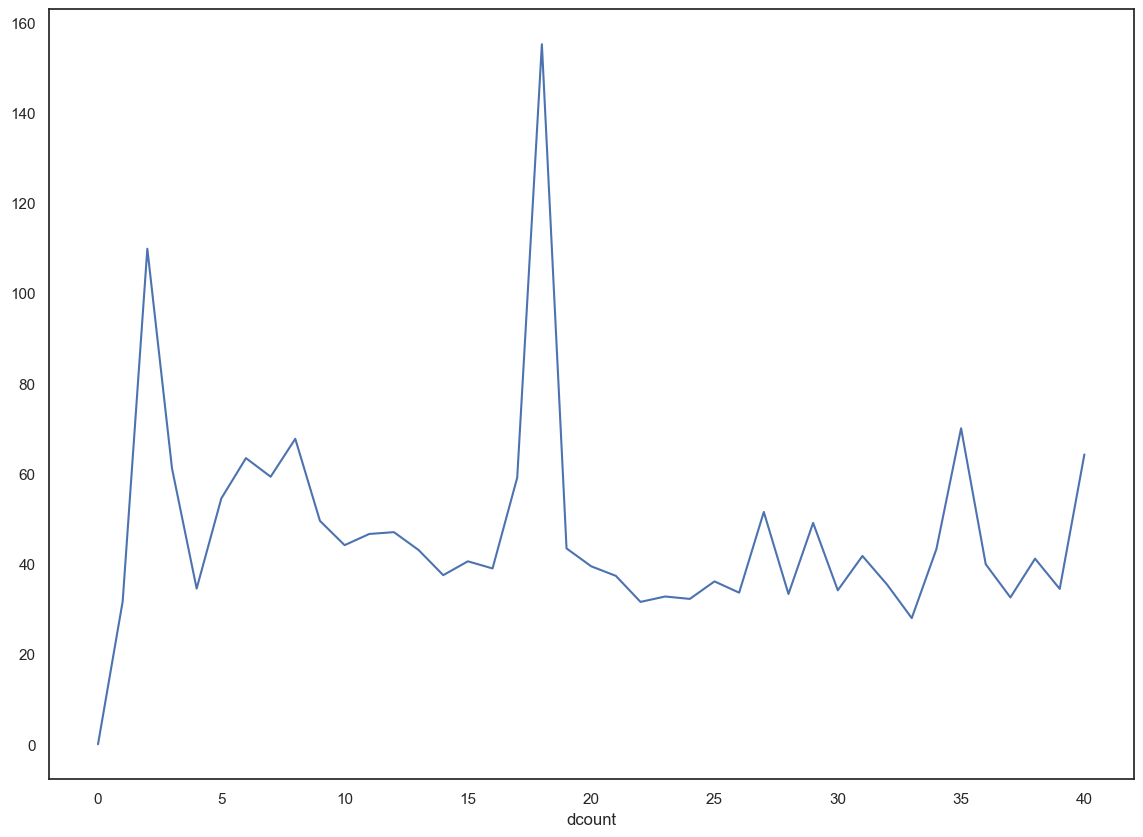

In [ ]:
lag = 1
train[f'mbd_lag_{lag}'] = train.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
train['dif'] = (train['microbusiness_density'] / train[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
train.loc[(train[f'mbd_lag_{lag}']==0), 'dif'] = 0
train.loc[(train[f'microbusiness_density']>0) & (train[f'mbd_lag_{lag}']==0), 'dif'] = 1
train['dif'] = train['dif'].abs()
train.groupby('dcount')['dif'].sum().plot()

# 3.Results

1. Mean outliers near 50% exept jauary 2021 end end of 2019. The same results for active
2. 

In [ ]:
train.to_csv(DATA_PROCESSED_PATH / "train_mod.csv", index=False)